# Ludwig test
## Installing virtualenv and ludwig on Ubuntu 18.04

``` bash
# Start from the text_classification directory
cd text_classification

# Get pip and virtualenv
sudo apt-get install python3-pip
pip3 install virtualenv

# Now set up a new virtualenv with a new python
virtualenv -p python3 venv
# Activate the venv
. venv/bin/activate
# Note, to deactivate the venv, just run "deactivate"

#Library prereq for ludwig 2
sudo apt-get install libgmp3-dev
sudo apt-get install libsndfile1

# Now install packages and ludwig 0.2.2.8 (0.3 is buggy)
pip install -r requirements.txt
pip install ludwig==0.2.2.8
pip install ludwig[viz]==0.2.2.8

# Other missing dependencies
pip install imblearn matplotlib

# Get Jupyter (to run this file)
pip install jupyter

```

## Splitting Moby Dick and Romeo and Juliet

``` bash
# Word wrap at 80 characters
fold -w 80 -s moby_dick.txt

# Now split the text every 5 lines, and prefix with a label
cd book_data
split -d -l 5 ../romeo_juliet.txt RJ_
split -d -l 5 ../moby_dick.txt MD_
```

## Key Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import subprocess
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline

## Import our Labeled Text into a CSV (via DataFrame)

In [2]:
# First, let's import the full collection of labeled texts
#
# All of the text is in "book_data" and begins with a label "MD_" for "Moby Dick" 
# or "RJ_" for Romeo and Juliet
#

filenames = []
texts = []
labels = []
path = "book_data"
# First let's
for file in os.listdir(path):
    if not file.startswith('.'):
        filenames.append(file)
        labels.append(file.split('_')[0])
        with open(os.path.join(path,file), 'r') as f:
            texts.append(f.read())

# We read the text and insert it into a pandas dataframe. Sklearn uses dataframes
# because it is a table class with nice analysis methods
labeled_data = pd.DataFrame()
labeled_data['text'] = texts
labeled_data['label'] = labels

# Display the first 6 rows to show that we successfully read it
labeled_data.head(6)

,text,label
0,"“Cook,” said Stubb, rapidly lifting a rather r...",MD
1,"\nA short space elapsed, and up into this nois...",MD
2,"said humorous Stubb one day, “he can never be ...",MD
3,and portion off their nieces with a few porpoi...,MD
4,as ordinary fish possess what is called a swim...,MD
5,"JULIET\nNow, good sweet nurse,--O Lord, why lo...",RJ


### Save as a CSV

In [3]:
# Remove any old training set data
! rm -f training_set.hdf5 training_set.json

# Now save the data as a csv file
labeled_data.to_csv("training_set.csv", index=False)
! head training_set.csv

text,label
"“Cook,” said Stubb, rapidly lifting a rather reddish morsel to his mouth, 
“don’t you think this steak is rather overdone? You’ve been beating this 
steak too much, cook; it’s too tender. Don’t I always say that to be good, 
a whale-steak must be tough? There are those sharks now over the side, don’t 
you see they prefer it tough and rare? What a shindy they are kicking up! Cook, 
",MD
"
A short space elapsed, and up into this noiselessness came Ahab alone from his 
cabin. Taking a few turns on the quarter-deck, he paused to gaze over the side, 


## Use Ludwig to Train a Model

In [4]:
!date
!rm -Rf results # Removes past runs
!ludwig experiment \
--data_csv training_set.csv \
--model_definition_file model_definition.yaml \
--output_directory ./results
!date


Thu Oct 15 17:10:40 EDT 2020
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

███████████████████████
█ █ █ █  ▜█ █ █ █ █   █
█ █ █ █ █ █ █ █ █ █ ███
█ █   █ █ █ █ █ █ █ ▌ █
█ █████ █ █ █ █ █ █ █ █
█     █  ▟█     █ █   █
███████████████████████
ludwig v0.2.2.8 - Experiment

Experiment name: experiment
Model name: run
Output path: ./results/experiment_run


ludwig_version: '0.2.2.8'
command: ('/home/butch/machine_learning/text_classification/venv/bin/ludwig experiment '
 '--data_csv training_set.csv --model_definition_file model_definition.yaml '
 '--output_directory ./results')
commit_hash: '056c9cf46f39'
random_seed: 42
input_data: 'training_set.csv'
model_definition: {   'c

Writing dataset
Writing train set metadata with vocabulary
Training set: 3333
Validation set: 443
Test set: 937

╒══════════╕
│ TRAINING │
╘══════════╛

2020-10-15 17:10:43.159735: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2020-10-15 17:10:43.183789: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 3801000000 Hz
2020-10-15 17:10:43.183994: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4a10d40 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2020-10-15 17:10:43.184017: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version

Epoch   1
Evaluation test : 100%|███████████████████████████| 8/8 [00:01<00:00,  6.55it/s]
Took 26.4253s
╒══════════╤════════╤════════════╤═════════════╕
│ label    │   loss │   accuracy │   hits_at_k │
╞══════════╪════════╪════════════╪═══


Finished: experiment_run
Saved to: ./results/experiment_run
Thu Oct 15 17:14:22 EDT 2020


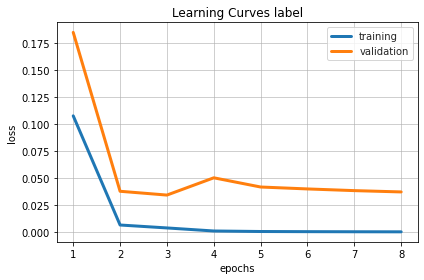

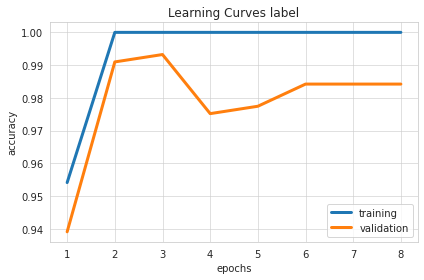

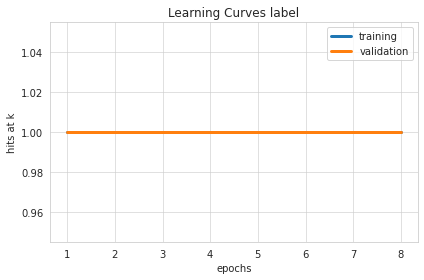

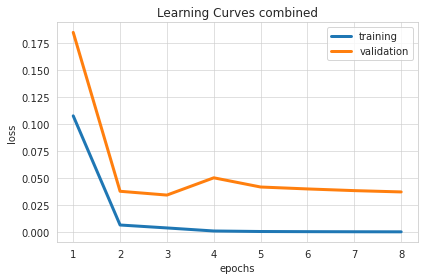

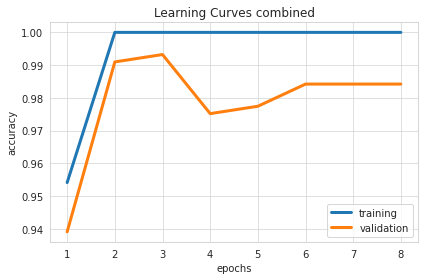

In [5]:
# Run visualize
# The following would create pdfs of the visualization
# !ludwig visualize -v learning_curves -trs results/experiment_run_0/training_statistics.json -tes results/experiment_run_0/test_statistics.json -od .

from ludwig import visualize
import json

with open('./results/experiment_run/training_statistics.json') as f:
    data = json.load(f)
 
visualize.learning_curves(data, None)


In [6]:
# Load a pretrained model
from ludwig.api import LudwigModel

model = LudwigModel.load('./results/experiment_run/model')

model.predict(pd.DataFrame({"text":["And yet I would it were to give again."]}))



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Restoring parameters from ./results/experiment_run/model/model_weights


,label_predictions,label_probabilities_<UNK>,label_probabilities_MD,label_probabilities_RJ,label_probability
0,RJ,6.159554e-16,0.240658,0.759342,0.759342


In [7]:
# Directly from MD
model.predict(pd.DataFrame({"text":["I might proceed with several more examples, one way or another known to me, of the great power and malice at times of the sperm whale. In more than one instance, he has been known, not only to chase the assailing boats back to their ships, but to pursue the ship itself, and long withstand all the lances hurled at him from its decks."]}))


,label_predictions,label_probabilities_<UNK>,label_probabilities_MD,label_probabilities_RJ,label_probability
0,MD,6.152805e-27,0.999817,0.000183,0.999817


In [8]:
model.predict(pd.DataFrame({"text":["Wouldst thou withdraw it? for what purpose, love?"]}))


,label_predictions,label_probabilities_<UNK>,label_probabilities_MD,label_probabilities_RJ,label_probability
0,RJ,4.497716e-17,0.003838,0.996162,0.996162


In [9]:
model.predict(pd.DataFrame({"text":["Is this sentence more like Shakespeare or like Moby Dick?"]}))


,label_predictions,label_probabilities_<UNK>,label_probabilities_MD,label_probabilities_RJ,label_probability
0,RJ,4.003937e-16,0.062002,0.937998,0.937998
